In [1]:
from Network_PER import *
from DriveSim import *

pygame 2.1.2 (SDL 2.0.18, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#시뮬레이션 학습 코드
EXP_COUNT = 6
n_runs = 10000
train_scores = np.zeros([EXP_COUNT,n_runs//100])
train_losses = np.zeros([EXP_COUNT,n_runs//100])

for exps in range(EXP_COUNT):
    wins = 0
    per = False
    if exps < 3:
        per = True
    lrate = 0.001
    print("learning rate:", lrate)
    agent = Agent(lr=lrate, gamma=0.999, n_actions=5, batch_size=64, epsilon=1.0, input_dims=[6], per_on=per)
    sim = DriveSimulator()
    epsilons = []
    avg_score = 0.0
    avg_loss = 0.0

    oe_a = 0.0
    oe_b = 0.0
    
    for i in range(n_runs):
        over = False
        sim.reset(frame_rate=3000)

        state = sim.get_sim_state()
        while not over:
            #print(state[0][0])
            #print(agent.choose_action(state))
            action, pred = agent.choose_action(state)
            state_, stpRwd, sim_over = sim.step(action)
            over = sim_over

            agent.store_transition(state, action, stpRwd, state_, over, pred)
            state = state_
            
            if pred > 5.0:
                oe_a += 1.0
            oe_b += 1.0

        Loss = agent.learn(exps)
        #overestimation detection


        agent.epsilon = round(1.0 - (float(i)/float(n_runs)),3)
        #scores.append(sim.agtRwd)
    
        avg_score += sim.agtRwd
        avg_loss += Loss
        if sim.episode_count % 100 == 0:
            avg_score /= 100
            avg_loss /= 100
            print('Episode', sim.episode_count, ', average score(last 100 episodes):', avg_score, \
                'average loss:', avg_loss, 'wins:', sim.win_count, 'eps:', agent.epsilon)


            print(f'DETECTED OVERESTIMATION: {oe_a/oe_b} ({oe_a}/{oe_b})')
            oe_a = 0.0
            oe_b = 0.0

            train_scores[exps, i//100] = avg_score
            train_losses[exps, i//100] = avg_loss
            avg_score = 0.0
            avg_loss = 0.0
            epsilons.append(agent.epsilon)

    agent.save_model(f'./models/q_20221224({exps})')
np.savetxt(f'20221224_scores.csv', train_scores, delimiter=",")
np.savetxt(f'20221224_losses.csv', train_losses, delimiter=",")

learning rate: 0.001
Use Prioritized Sampling: True
q_next weight set!
Episode 100 , average score(last 100 episodes): -4.573348956753355 average loss: 0.10871584229171276 wins: 2 eps: 0.99
DETECTED OVERESTIMATION: 0.0 (0.0/8109.0)
Episode 200 , average score(last 100 episodes): -4.627875538075113 average loss: 0.11544136874377728 wins: 4 eps: 0.98
DETECTED OVERESTIMATION: 0.0 (0.0/7983.0)
q_next weight set!
Episode 300 , average score(last 100 episodes): -4.533969386708314 average loss: 0.08381915787700564 wins: 7 eps: 0.97
DETECTED OVERESTIMATION: 0.0001271294177472667 (1.0/7866.0)
Episode 400 , average score(last 100 episodes): -4.604687990473318 average loss: 0.06959656425286084 wins: 9 eps: 0.96
DETECTED OVERESTIMATION: 0.0 (0.0/8281.0)
q_next weight set!
Episode 500 , average score(last 100 episodes): -4.715009105536549 average loss: 0.05348167140036821 wins: 9 eps: 0.95
DETECTED OVERESTIMATION: 0.0 (0.0/8601.0)
Episode 600 , average score(last 100 episodes): -4.468894708769125 a

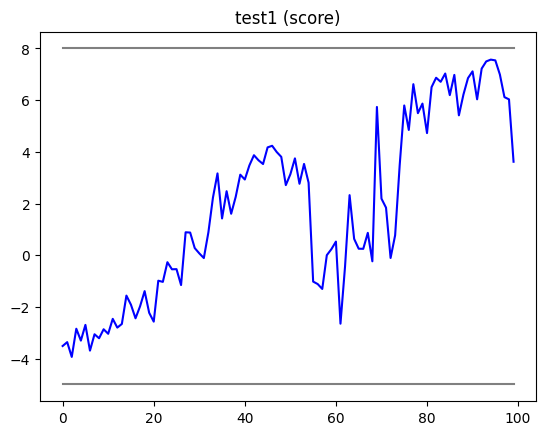

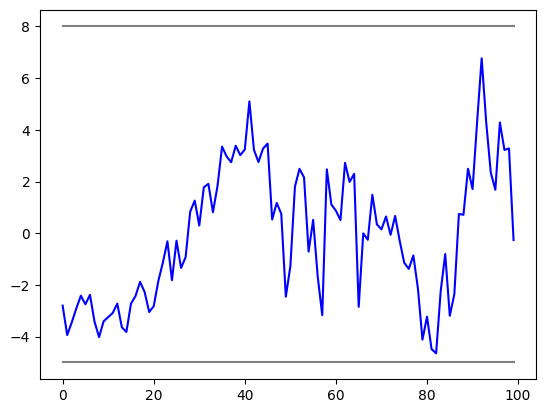

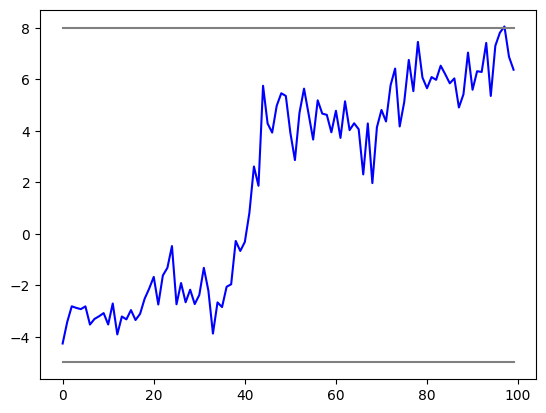

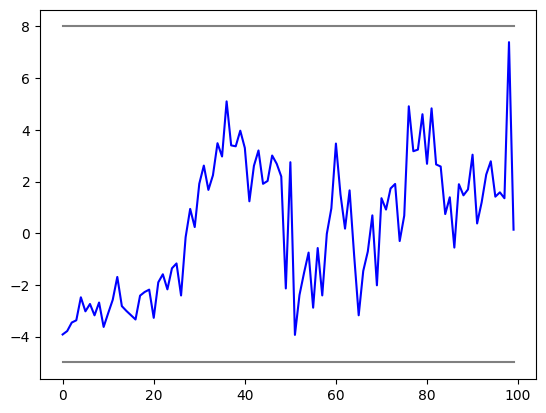

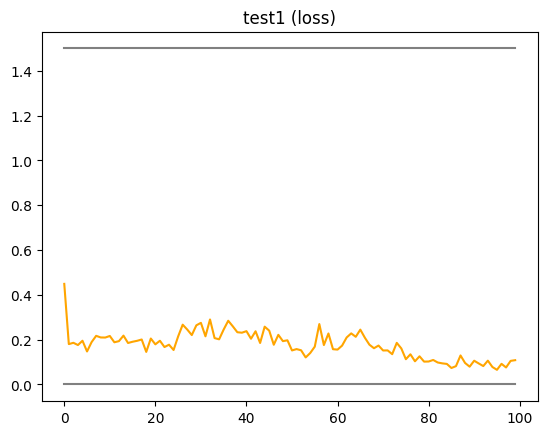

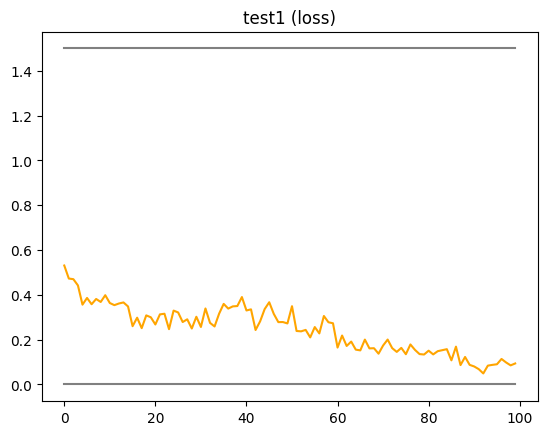

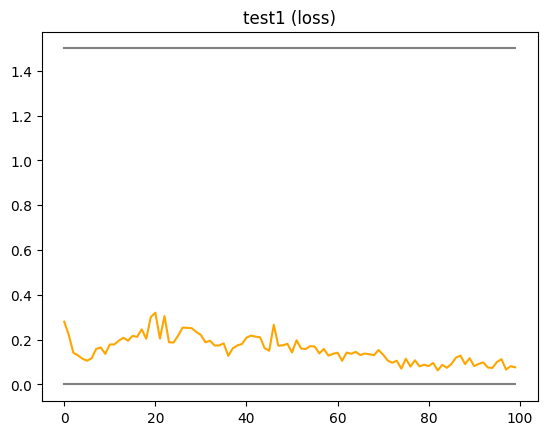

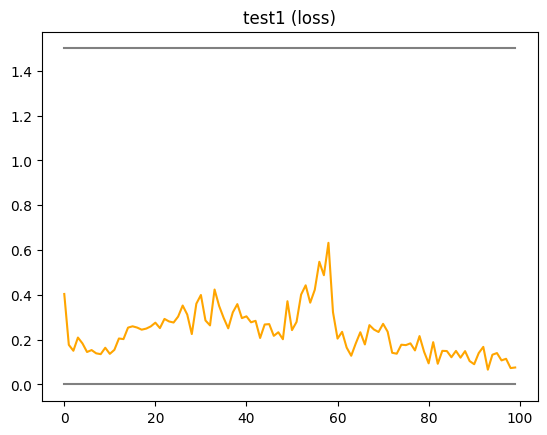

In [5]:

def save_graph(date, label):
    scores = np.genfromtxt(date + '_scores.csv', delimiter=',')
    losses = np.genfromtxt(date + '_losses.csv', delimiter=',')

    # Plot Score
    plt.title(label + ' (score)')
    for i in range(EXP_COUNT):
        plt.plot(scores[i], 'b')
        plt.plot(8.0 * np.ones_like(scores[i]), 'gray') #Score 상한선
        plt.plot(-5.0 * np.ones_like(scores[i]), 'gray') #Score 하한선
        plt.show()
    #plt.savefig(date + '_score.png')
    #plt.show()

    for i in range(EXP_COUNT):
        plt.title(label + ' (loss)')
        #Plot Loss
        plt.plot(losses[i], 'orange')
        plt.plot(1.5 * np.ones_like(losses[i]), 'gray') #Loss 상한선
        plt.plot(np.zeros_like(losses[i]), 'gray') #Loss 하한선
        plt.show()
    #plt.savefig(date + '_loss.png')
    #plt.show()

save_graph(date = '20221209', label = 'test1')

In [ ]:
# 이 밑에는 예전에 쓰던 코드. . .

In [ ]:
#이전에 저장한 학습 데이터 불러오기
train_scores_2 = np.genfromtxt('20221014_concat_train_scores.csv', delimiter=',')

for exps in range(EXP_COUNT):
    plt.plot(train_scores_1[exps], 'b')
plt.plot(train_scores_1.mean(axis=0), 'r')
plt.show()

for exps in range(EXP_COUNT):
    print(train_scores_2[exps])
    plt.plot(train_scores_2[exps], 'b')
plt.plot(train_scores_2.mean(axis=0), 'r')
plt.show()

plt.plot(train_scores_2.mean(axis=0), 'r')
plt.plot(train_scores_1.mean(axis=0), 'b')
plt.savefig('compare_20221004_per')

In [ ]:
#학습 데이터 비교!!!!!
scores_Random = np.genfromtxt('20221017_concat_train_scores.csv', delimiter=',')
scores_Error_PER = np.genfromtxt('20221016_concat_train_scores.csv', delimiter=',')
scores_Reward_PER = np.genfromtxt('20221014_concat_train_scores.csv', delimiter=',')

plt.plot(scores_Random.mean(axis=0), 'k', label='Random')
plt.plot(scores_Error_PER.mean(axis=0), 'b', label='TD-Error based')
plt.plot(scores_Reward_PER.mean(axis=0), 'r', label='Reward based')
plt.legend()
plt.savefig("compare_sampling_methods_20221017.png")

In [ ]:
score_max = scores_Random.min(axis=0)
score_min = scores_Random.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'gray', alpha = 0.1)

score_max = scores_Error_PER.min(axis=0)
score_min = scores_Error_PER.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'b', alpha = 0.1)

score_max = scores_Reward_PER.min(axis=0)
score_min = scores_Reward_PER.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'r', alpha = 0.1)


plt.plot(scores_Random.mean(axis=0), 'gray', label='Random')
plt.plot(scores_Error_PER.mean(axis=0), 'b', label='TD-Error based')
plt.plot(scores_Reward_PER.mean(axis=0), 'r', label='Reward based')

plt.xlabel('Episodes/100')
plt.ylabel('Average Reward (during last 100 episodes)')
plt.legend()

plt.savefig("compare_sampling_methods_with_range_20221017.png")

In [ ]:
score_max = scores_Random.min(axis=0)
score_min = scores_Random.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'gray', alpha = 0.1)

score_max = scores_Reward_PER.min(axis=0)
score_min = scores_Reward_PER.max(axis=0)
plt.fill_between(range(100), score_max, score_min, color = 'orange', alpha = 0.1)


plt.plot(scores_Random.mean(axis=0), 'gray', label='Random')
plt.plot(scores_Reward_PER.mean(axis=0), 'orange', label='Reward based')

plt.xlabel('Episodes/100')
plt.ylabel('Average Reward (during last 100 episodes)')
plt.legend()

plt.savefig("compare_aw_with_range_20221017.png")

In [ ]:
np.savetxt('20221017_concat_train_scores.csv', train_scores_1, delimiter=",")